In [2]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import statsmodels.api as sm

from patsy import dmatrix

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [4]:
try:
    blossom_data = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossom_data = pd.read_csv(pm.get_data("cherry_blossoms.csv"), sep=";")


blossom_data.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [5]:
blossom_data = blossom_data.dropna(subset=["doy"]).reset_index(drop=True)
blossom_data.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


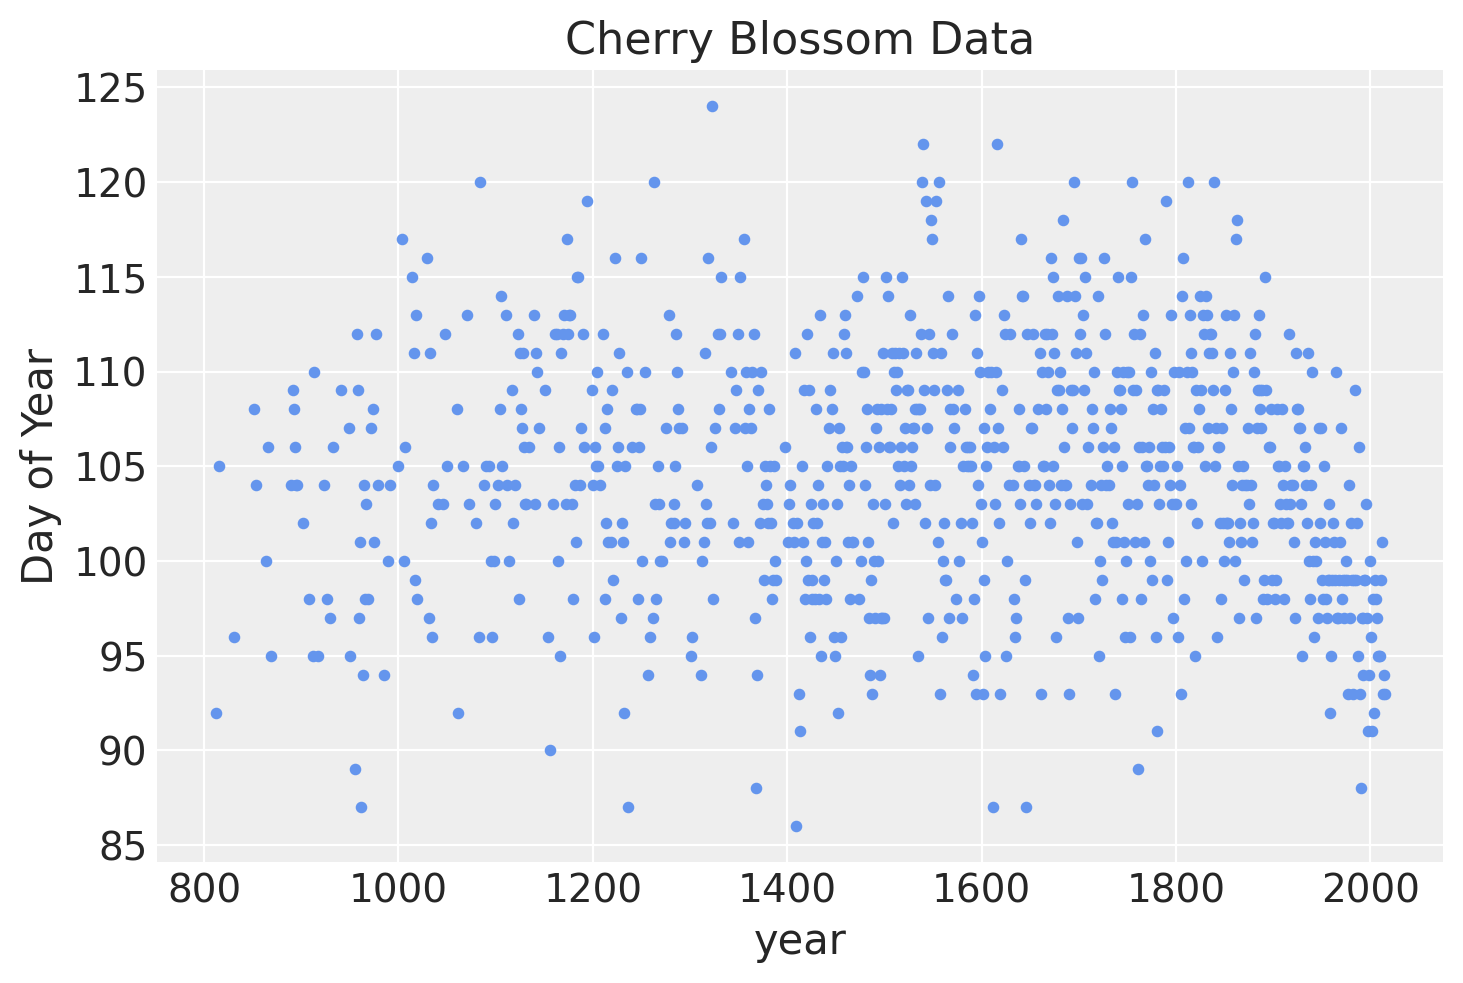

In [6]:
blossom_data.plot.scatter(
    "year", "doy", color="cornflowerblue", s=10, title="Cherry Blossom Data", ylabel="Day of Year"
);

In [7]:
num_knots = 15
knot_list = np.quantile(blossom_data.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

In [8]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": blossom_data.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

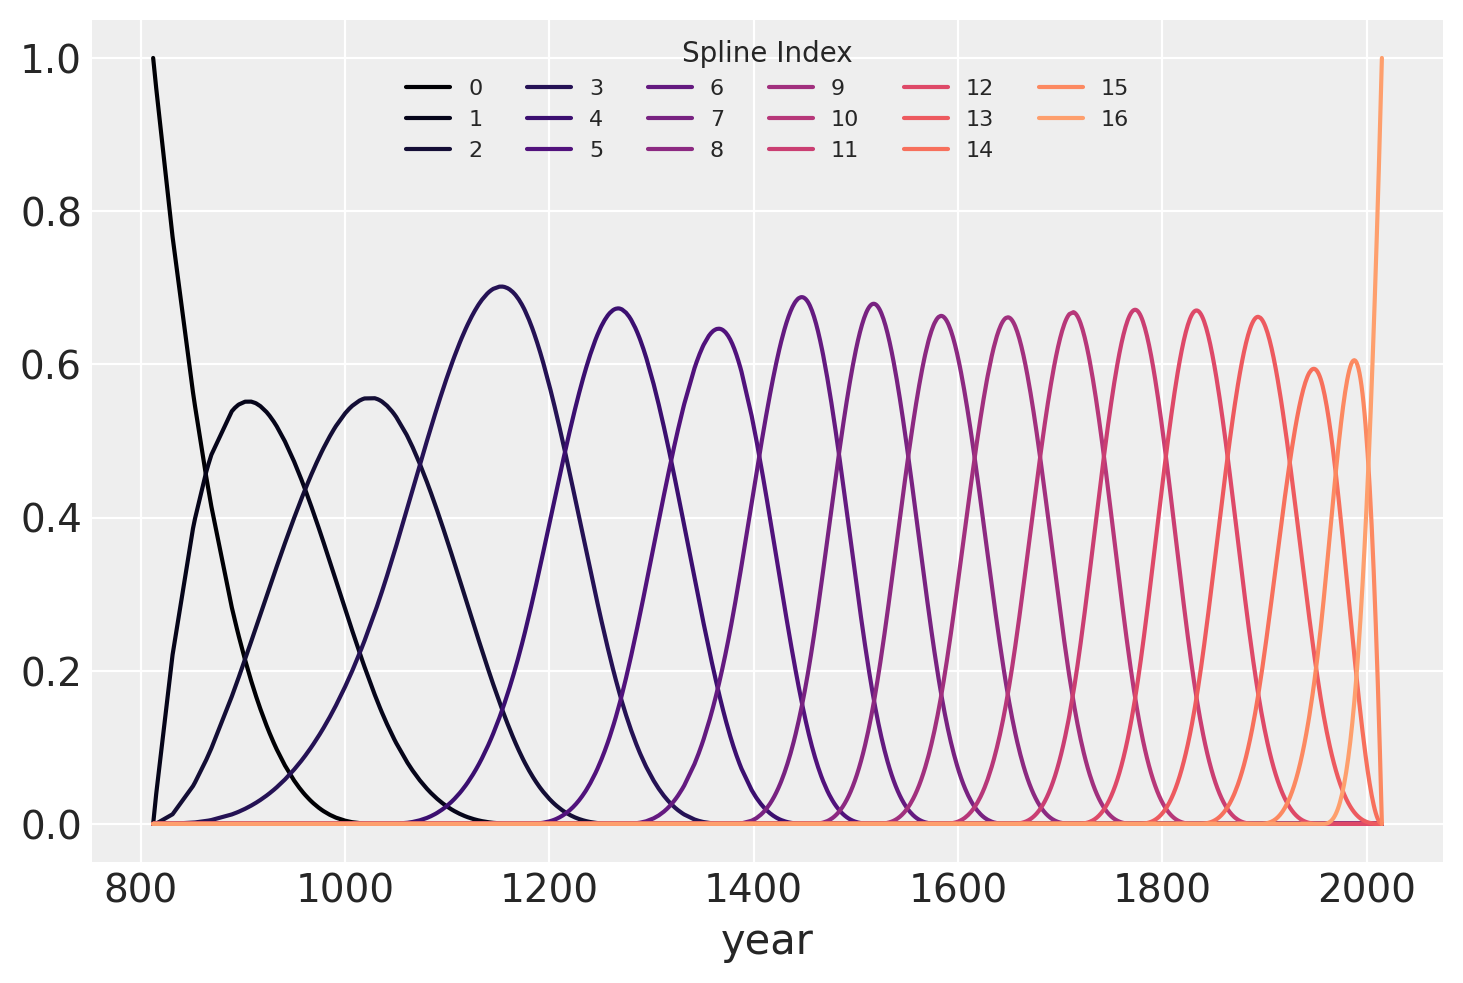

In [9]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=blossom_data.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("year", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

,year,spline_i,value
13232,812,16,0.000000
13233,815,16,0.000000
13234,831,16,0.000000
13235,851,16,0.000000
13236,853,16,0.000000
...,...,...,...
14054,2011,16,0.810088
14055,2012,16,0.855083
14056,2013,16,0.901713
14057,2014,16,0.950009


In [12]:
COORDS = {"obs": np.arange(len(blossom_data.doy)), "splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sd=3, dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=blossom_data.doy, dims="obs")


You can find the C code in this temporary file: C:\Users\thodson\AppData\Local\Temp\1\theano_compilation_error_px4zqhe4


Exception: ("Compilation failed (return status=1): C:\\Users\\thodson\\AppData\\Local\\Temp\\1\\ccWACddX.o: In function `run':\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:99: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:124: undefined reference to `__imp_PyExc_ValueError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:130: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:158: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:195: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:210: undefined reference to `__imp_PyExc_ValueError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:479: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:\\Users\\thodson\\AppData\\Local\\Temp\\1\\ccWACddX.o: In function `_Py_INCREF':\r. c:/users/thodson/appdata/local/programs/python/python39/include/object.h:408: undefined reference to `__imp__Py_NoneStruct'\r. C:\\Users\\thodson\\AppData\\Local\\Temp\\1\\ccWACddX.o: In function `run':\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:485: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:244: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:265: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:173: undefined reference to `__imp_PyExc_TypeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:179: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:515: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:514: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:516: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:259: undefined reference to `__imp_PyExc_TypeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:279: undefined reference to `__imp__Py_NoneStruct'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:294: undefined reference to `__imp_PyExc_ValueError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:328: undefined reference to `__imp_PyExc_NotImplementedError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:349: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:216: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:343: undefined reference to `__imp_PyExc_TypeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:300: undefined reference to `__imp_PyExc_RuntimeError'\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:397: undefined reference to `__imp_PyExc_RuntimeError'\r. C:\\Users\\thodson\\AppData\\Local\\Temp\\1\\ccWACddX.o: In function `instantiate':\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:550: undefined reference to `__imp_PyExc_TypeError'\r. C:\\Users\\thodson\\AppData\\Local\\Temp\\1\\ccWACddX.o: In function `_import_array':\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1480: undefined reference to `__imp_PyCapsule_Type'\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1481: undefined reference to `__imp_PyExc_RuntimeError'\r. C:\\Users\\thodson\\AppData\\Local\\Temp\\1\\ccWACddX.o: In function `PyInit_m31975b6dadb59d49af3f2b36405378825884299512ee0ed9081be33fa591d30d':\r. C:/Users/thodson/AppData/Local/Theano/compiledir_Windows-10-10.0.19041-SP0-Intel64_Family_6_Model_142_Stepping_12_GenuineIntel-3.9.2-64/tmp3b5uzskz/mod.cpp:583: undefined reference to `__imp_PyExc_ImportError'\r. C:\\Users\\thodson\\AppData\\Local\\Temp\\1\\ccWACddX.o: In function `_import_array':\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1512: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1496: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1502: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1524: undefined reference to `__imp_PyExc_RuntimeError'\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1476: undefined reference to `__imp_PyExc_AttributeError'\r. c:/users/thodson/appdata/local/programs/python/python39/lib/site-packages/numpy/core/include/numpy/__multiarray_api.h:1488: undefined reference to `__imp_PyExc_RuntimeError'\r. collect2.exe: error: ld returned 1 exit status\r. ", 'FunctionGraph(Elemwise{true_div,no_inplace}(TensorConstant{1.0}, TensorConstant{0.04}))')